# Convolutional Neural Networks (CNNs) For Brain Tumor Classification

<p align="center" style="margin: 0 auto;">
  <img src="img/BrainTumor_intro_photo.jpg" alt="Brain MRI" style="display: block; margin: 0 auto;">
</p>

CNNs are a class of deep neural networks commonly used for analyzing visual imagery. They are particularly effective for image classification and recognition tasks due to their ability to capture spatial hierarchies in images.

### Key Components:

1. **Convolutional Layers**:
   - **Filters/Kernels**: Small matrices that slide over the input data to detect patterns such as edges, textures, or shapes.
   - **Convolution Operation**: The filter is applied to the input data, producing a feature map that highlights the presence of specific features.

2. **Activation Function**:
   - Typically, a non-linear function like ReLU (Rectified Linear Unit) is applied to introduce non-linearity into the model, allowing it to learn complex patterns.

3. **Pooling Layers**:
   - **Max Pooling**: Reduces the spatial dimensions of the feature maps by taking the maximum value in a defined window, helping to make the model invariant to small translations.
   - **Average Pooling**: Similar to max pooling but takes the average value instead.

4. **Flattening**:
   - Converts the 2D feature maps into a 1D vector, preparing it for the fully connected layers.

5. **Fully Connected Layers**:
   - Neurons in these layers are fully connected to all activations in the previous layer, similar to traditional neural networks. They combine the features to predict the final output.

6. **Output Layer**:
   - Uses an activation function like softmax for multi-class classification, providing probabilities for each class.

CNNs have revolutionized the field of computer vision and are widely used in applications such as image and video recognition, medical image analysis, and autonomous vehicles. In the context of brain tumors, CNNs are especially valuable for analyzing medical imaging methodologies like MRI, CT Scans, and many others. Accurate networks can quickly detect and classify tumors, allowing for early detection and more effective treatment for better patient outcomes.

### Packages and Imports
We will use packages that help with preprocessing the data and splitting the data into training, testing, and validation sets. Additionally, we will also import `os` to make sure we are in the correct working directory and the `preprocess_data` function from our `Preprocessing.py` script. The code below loads all the necessary components for preprocessing and sets a seed to ensure reproducibility of the models. This helps minimize the impact of random variance, allowing us to attribute results to the model's performance rather than random chance..

In [30]:
import os
import pickle
from scripts.drafts.Preprocessing import preprocess_data
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

# set global random seeds
np.random.seed(12345)

## Preprocessing
First we have to find the path to our current working directory and add the paths of the raw image data files (jpg's) so that we can access them when we do our preprocessing.

In [31]:
# Save pathway to working directory
my_dir = os.getcwd()
print(f"Current working directory: {str.split(my_dir, '/')[-1]}")

# Save pathways of raw data files
glioma_path = my_dir + "/data/glioma_tumor"
meningioma_path = my_dir + "/data/meningioma_tumor"
pituitary_path = my_dir + "/data/pituitary_tumor"
normal_path = my_dir + "/data/no_tumor"

Current working directory: vignette-cnn


Next we preprocess the raw data in order to train our neural network model. Since there are thousands of images in the raw data, we decided to select a smaller sample to work with while we train our model.

Our preprocessing includes:

- Reading .jpg image
- Resizing each image (224x224 in this case) for uniform input size to the model
- Color conversion (BGR to RGB)
- Grayscale handling: If an image is grayscale, it is converted to a 3-channel format by stacking the grayscale data across the three channels.
- Normalization of pixel values from [0,255] to [0,1] for numerical stability during training
- Label extraction of the image based on the folder name (`glioma_tumor`, `meningioma_tumor`, `pituitary_tumor`, `no_tumor`)

In [32]:
glioma_data, glioma_labels = preprocess_data(glioma_path, 224)
meningioma_data, meningioma_labels = preprocess_data(meningioma_path, 224)
pituitary_data, pituitary_labels = preprocess_data(pituitary_path, 224)
normal_data, normal_labels = preprocess_data(normal_path, 224)

Total files in /Users/reese/Documents/School/UC Santa Barbra/PSTAT/PSTAT197/vignette-cnn/data/glioma_tumor: 901
Processed 901 images.
Total files in /Users/reese/Documents/School/UC Santa Barbra/PSTAT/PSTAT197/vignette-cnn/data/meningioma_tumor: 913
Processed 913 images.
Total files in /Users/reese/Documents/School/UC Santa Barbra/PSTAT/PSTAT197/vignette-cnn/data/pituitary_tumor: 844
Processed 844 images.
Total files in /Users/reese/Documents/School/UC Santa Barbra/PSTAT/PSTAT197/vignette-cnn/data/no_tumor: 438
Processed 438 images.


Next we can combine all of our images and their labels into separate arrays. From here we partition our data into training and testing sets. We also created a validation set so that we can test our model accuracy as it is training. The labels must also be one hot encoded so that our model is able to process what category each image falls into. Note, running this chunk can require more time.

In [33]:
# combine images and labels into their respective dataframes
print("stacking data")
data = np.vstack([glioma_data, meningioma_data, pituitary_data, normal_data])
labels = np.hstack([glioma_labels, meningioma_labels, pituitary_labels, normal_labels])

# split data into training, validation, and testing sets
train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size=0.2, stratify=labels, shuffle=True, random_state=12345)
train_data, val_data, train_labels, val_labels = train_test_split(train_data, train_labels, test_size=0.25, stratify=train_labels, shuffle=True, random_state=12345)

ohe = OneHotEncoder(sparse_output=False)
train_labels = ohe.fit_transform(np.array(train_labels).reshape(-1, 1))
val_labels = ohe.transform(np.array(val_labels).reshape(-1, 1))
test_labels = ohe.transform(np.array(test_labels).reshape(-1, 1))

# Print shapes to verify split
print(f"Training set shape: {train_data.shape}")
print(f"Validation set shape: {val_data.shape}")
print(f"Test set shape: {test_data.shape}")
print(train_labels.shape, "\n", ohe.inverse_transform(train_labels)[:3])

stacking data
Training set shape: (1857, 224, 224, 3)
Validation set shape: (619, 224, 224, 3)
Test set shape: (620, 224, 224, 3)
(1857, 4) 
 [['pituitary']
 ['pituitary']
 ['meningioma']]


## Visual Inspection
In order to better understand the data we're working with and to ensure that it was correctly preprocessed and is ready for our model, we will look at it ourselves. First we look at a histogram to visualize the class distribution of our data.

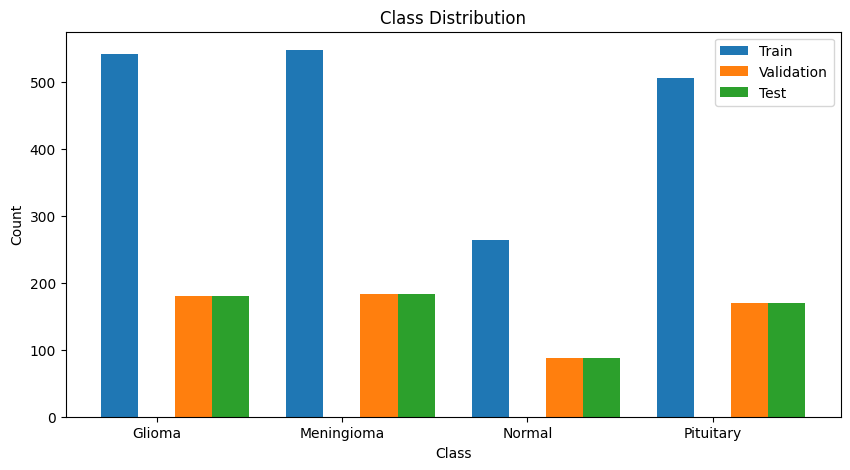

In [27]:
# visualize class distribution
train_distribution = np.sum(train_labels, axis=0)
val_distribution = np.sum(val_labels, axis=0)
test_distribution = np.sum(test_labels, axis=0)

classes = ['Glioma', 'Meningioma', 'Normal', 'Pituitary']
x_axis = np.arange(len(classes))

plt.figure(figsize=(10, 5))
plt.bar(x_axis - 0.2, train_distribution, width=0.2, label='Train')
plt.bar(x_axis + 0.2, val_distribution, width=0.2, label='Validation')
plt.bar(x_axis + 0.4, test_distribution, width=0.2, label='Test')
plt.xticks(x_axis, classes)
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Class Distribution')
plt.legend()
plt.show()


Next, we want to see what our observations look like to have a better understanding of what data we are working with. Displayed below are a few images of x-rays from each category of our brain cancer data. The images show that an x-ray of a brain with cancer has a visible lump in it, while a scan of a normal brain does not have any features that particularly stand out.

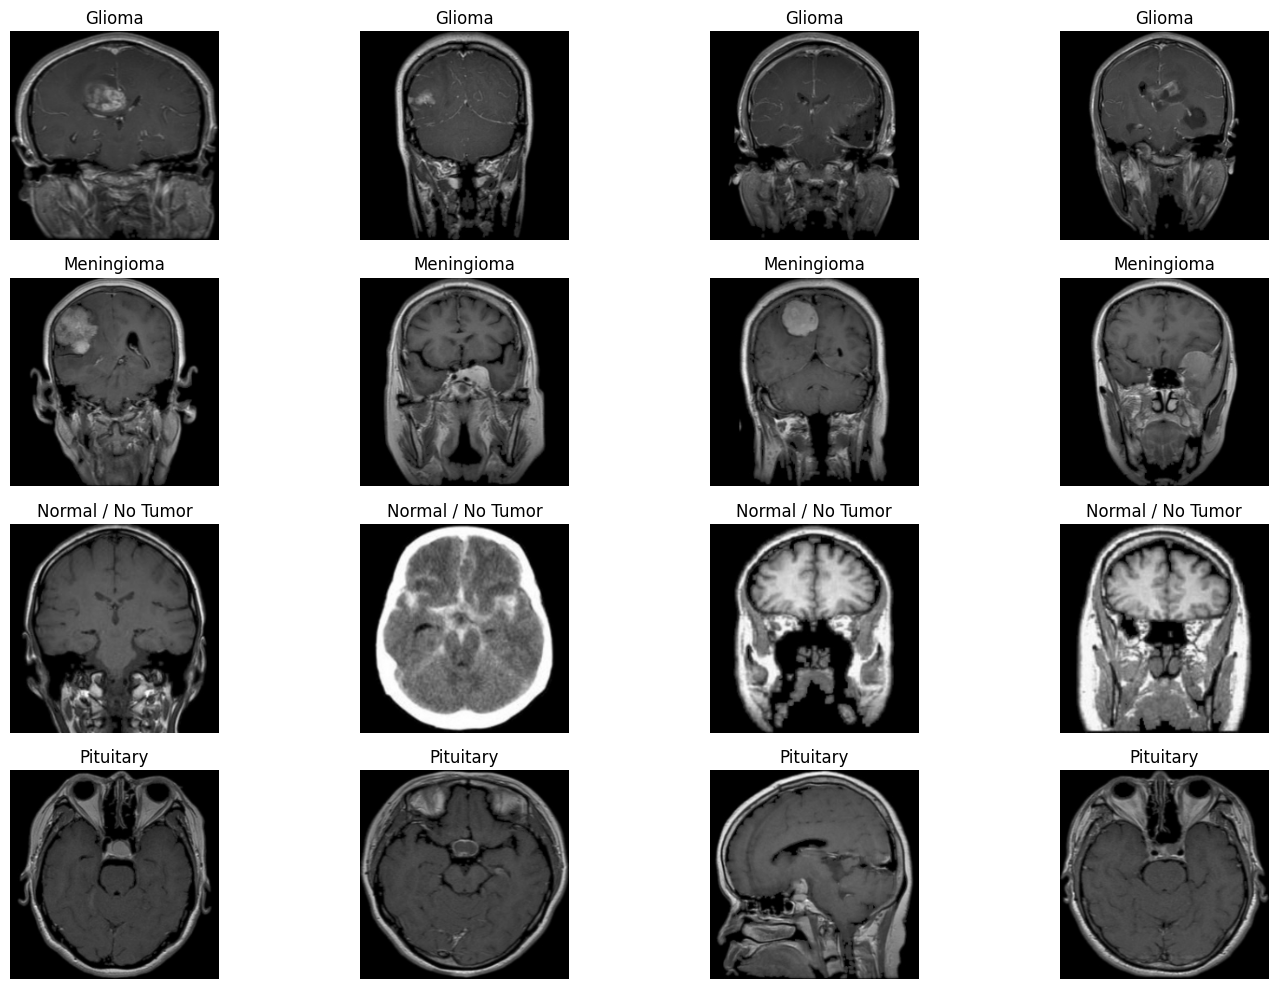

In [28]:
# show a few images from each class
unique_labels = np.unique(labels)
num_images_per_class = 4 # Number of images to display per class
plt.figure(figsize=(15, 10))  # Set figure size
for i, label in enumerate(unique_labels):
    class_indices = np.where(labels == label)[0]  # Get indices of images for the current label
    for j in range(num_images_per_class):
        if j < len(class_indices):  # Check if there are enough images for the class
            plt.subplot(len(unique_labels), num_images_per_class, i * num_images_per_class + j + 1)
            plt.imshow(data[class_indices[j]], cmap='gray')  # Display the j-th image of the i-th class
            plt.axis('off')
            plt.title(str.capitalize(label) if label in ['glioma', 'meningioma', 'pituitary'] else 'Normal / No Tumor')
plt.tight_layout()
#plt.savefig(my_dir + "/scripts/drafts/img/data_visualization.png")
plt.show()

# Modeling

### Import packages
Before we begin modeling, we must import `keras` so that we can build our neural networks. We also import a few functions from `keras` so that we can more easily call them later on.

In [34]:
import keras
import tensorflow as tf
import keras_tuner as kt
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, GlobalAveragePooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.metrics import confusion_matrix, classification_report

# Set seed
tf.random.set_seed(12345)
keras.utils.set_random_seed(12345)

## Building Our Models
In this section, we will create a simple convolutional layered model as a baseline to evaluate how well a CNN can train on our dataset.

### What is a CNN?
A CNN (Convolutional Neural Network) specializes in processing image data. It detects spatial hierarchies and patterns through layers of convolutional filters, significantly reducing the number of parameters compared to traditional feed-forward networks.

### Simple CNN Model Flow
- **Convolutional Layers**: Filters slide over the input image to detect shapes and edges.
- **Pooling Layers**: Max or average pooling reduces the dimensionality of the feature maps, keeping the most prominent features.
- **Flattening**: The output is flattened to feed into dense layers.
- **Dense Layers**: These layers combine features to predict the final output.

#### Mathematical Optimization
To optimize the number of units in our dense layers, we aim to minimize the loss function:
$$
\min_{\theta} \left[ 
\frac{1}{n} \sum_{i=1}^{n} \text{Loss}(f_{\theta}(x_i), y_i) + 
\lambda \cdot \text{Regularization}(\theta)\right]
$$
This ensures that we neither underfit nor overfit the model.

### Code Implementation with Keras API

In [35]:
# build a simple CNN model for baseline
inputs = Input(shape=(128, 128, 3), name='input_layer') # initialize the input layer
x = Conv2D(32, kernel_size=(3,3), activation='relu', name='conv1')(inputs) # pass the input to the first convolution layer
x = MaxPooling2D(2, name='pool1')(x) # pass the output of the first convolution layer to the first maxpooling layer
x = Conv2D(64, kernel_size=(3,3), activation='relu', name='conv2')(x) # pass the output of the first maxpooling layer to the second convolution layer
x = MaxPooling2D(2, name='pool2')(x) # pass the output of the second convolution layer to the second maxpooling layer
x = Flatten(name='flatten')(x) # flatten the output of the second maxpooling layer
x = Dense(128, activation='relu', name='dense1')(x) # pass the output of the flatten layer to the first dense layer
x = Dropout(0.3, name='dropout1')(x) # etc...
outputs = Dense(4, activation='softmax', name='output_layer')(x) 

simple_model = Model(inputs=inputs, outputs=outputs) # initialize the model
simple_model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy', 'AUC'])
simple_model.summary()

Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1 (Conv2D)                  │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool1 (MaxPooling2D)            │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2 (Conv2D)                  │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool2 (MaxPooling2D)            │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 57600)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense1 (Dense)                  │ (None, 128)            │     7,372,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout1 (Dropout)              │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,392,836 (28.20 MB)

 Trainable params: 7,392,836 (28.20 MB)

 Non-trainable params: 0 (0.00 B)

### Loss Function Choice:
Since we have already encoded our labels using the `OneHotEncoder` from scikit-learn, we select `categorical_crossentropy` as our loss function. If the labels were not encoded, we would need to use `sparse_categorical_crossentropy` instead.

# Training the model
- We include a `early-stopping` callback which will halt the model from updating on the training data as over too many iterations, with no improvements, we deem this to be over-fitting.
- Validation is included so we can monitor how it performs on unseen data
Here we can resize back to 128 for quicker training times, but may lose out on performance.
- We then can use the **.fit()** function to train the neural network using the data provided above. 

In [36]:
# resize data
train_data_resized = np.zeros((train_data.shape[0], 128, 128, 3))
import cv2
for i, image in enumerate(train_data):
    train_data_resized[i] = cv2.resize(image, (128, 128))

val_data_resized = np.zeros((val_data.shape[0], 128, 128, 3))
for i, image in enumerate(val_data):
    val_data_resized[i] = cv2.resize(image, (128, 128))

test_data_resized = np.zeros((test_data.shape[0], 128, 128, 3))
for i, image in enumerate(test_data):
    test_data_resized[i] = cv2.resize(image, (128, 128))

In [37]:
# Early stopping will stop training when the validation loss stops improving for a few epochs, preventing overfitting
early_stopping = EarlyStopping(monitor='val_accuracy', 
                               patience=5, verbose=1, 
                               restore_best_weights=True)
# train the model with .fit(). uncoment to run, but we have saved the model in the previous cell

#history = simple_model.fit(
#    train_data_resized,
#    train_labels,
#    validation_data=(val_data_resized, val_labels), # Convert sparse matrix
#    epochs=20,
#    batch_size=32, # mini batch size
#    callbacks=[early_stopping]
#)
# save model
#simple_model.save(my_dir + "/scripts/drafts/models/simple_model.keras")

In [53]:
simple_model = keras.models.load_model(my_dir + "/scripts/drafts/models/simple_model.keras")
# Evaluate model on test set
test_loss, test_accuracy, test_auc = simple_model.evaluate(test_data_resized, test_labels)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")
print(f"Test AUC: {test_auc}")

# classification report
y_pred = simple_model.predict(test_data_resized)
test_labels_classes = ohe.inverse_transform(test_labels)
y_pred_classes = ohe.inverse_transform(y_pred)
print(classification_report(test_labels_classes, y_pred_classes))

# confusion matrix
print(confusion_matrix(test_labels_classes, y_pred_classes).T)

20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - AUC: 0.9303 - accuracy: 0.7859 - loss: 1.0649
Test Loss: 0.9708671569824219
Test Accuracy: 0.7887097001075745
Test AUC: 0.9317619800567627
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step
              precision    recall  f1-score   support

      glioma       0.72      0.84      0.78       180
  meningioma       0.82      0.68      0.74       183
          no       0.78      0.83      0.80        88
   pituitary       0.86      0.83      0.84       169

    accuracy                           0.79       620
   macro avg       0.79      0.79      0.79       620
weighted avg       0.79      0.79      0.79       620

[[152  35   8  16]
 [ 11 124   5  12]
 [  8  12  73   1]
 [  9  12   2 140]]


The output from training the simple CNN shows how the accuracy and loss on the training and validation sets change over time. Additionally, when testing our model on the testing set we achieved an accuracy of about 70% percent. While this model had a simple architecture and only ran for 15 epochs, more complex models run over more epochs will create code outputs that are hard to read. Thus it's better to graph the accuracy and loss values and see how they change as the CNN trains.

## Plotting accuracy and loss

We can then use our model to plot how accuracy and loss change over time in the training and validation sets

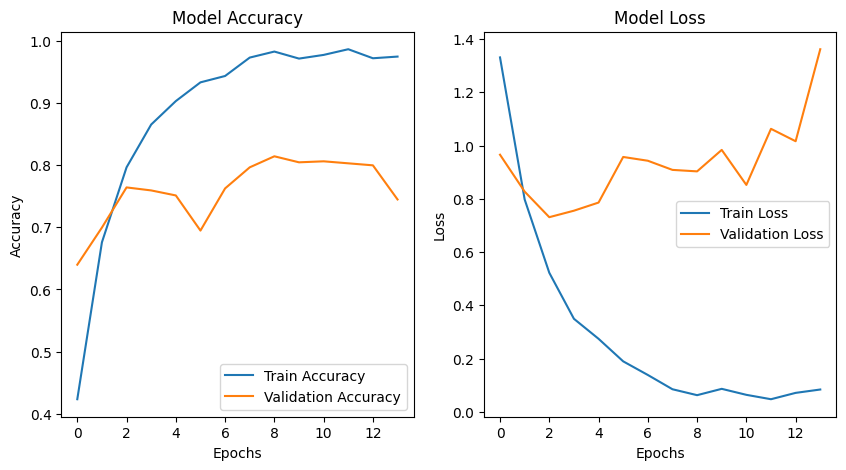

In [39]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].plot(history.history['accuracy'], label='Train Accuracy')
ax[0].plot(history.history['val_accuracy'], label='Validation Accuracy')
ax[0].set_title('Model Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].legend()
ax[1].plot(history.history['loss'], label='Train Loss')
ax[1].plot(history.history['val_loss'], label='Validation Loss')
ax[1].set_title('Model Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].legend()
plt.show()

Overall, the model quickly improves its accuracy and loss on the training set, which is expected. However, the plots show that the accuracy of the model falters on the validation set, with its best accuracy at epoch six. In addition to the test accuracy of 80%, the wavering accuracy on the validation set suggests that this simple CNN architecture isn't a good choice for correctly predicting these photos (after all, you wouldn't want a doctor that can only correctly identify cancer 80% of the time). Thus, we continue by experimenting with other CNN architectures and using Hyperband tuning to optimize our model and achieve a higher test accuracy.

## Hyperparameter Tuning
We will apply Hyperband Parameter Tuning to find the best set of hyperparameters for our model. This process is crucial as it can significantly enhance model performance by optimizing the learning process.

### List of Hyperparameters to Tune:
- **Filter Size**: The number of different filters applied to the input image (e.g., 32, 64, 128).
- **Kernel Size**: The dimensions of the matrix used for convolution (e.g., 3x3, 4x4, 5x5).
- **Units**: The number of neurons in the dense layer after flattening the convolved input image (e.g., 256, 512, 1024).
- **Dropout Rate**: The fraction of neurons to drop during training to prevent overfitting (e.g., 0.3, 0.5).
- **Batch Sizes**: The number of samples processed before the model is updated. Larger batch sizes can reduce computation time but may lead to lower accuracy due to less diverse data (e.g., 16, 32, 64).

In [40]:
# building a hyperband model to find the best model architecture
def build_model(hp):
    '''function to build a CNN model with a tuner object'''
    # initialize the model
    model = Sequential()
    model.add(Conv2D(filters=hp.Int('conv_1_filter', min_value=32, max_value=128, step=16),
               kernel_size=hp.Choice('conv_1_kernel', values=[3,4,5]),
               activation='relu', input_shape=(128, 128, 3)))
    model.add(MaxPooling2D(2))
    model.add(Conv2D(filters=hp.Int('conv_2_filter', min_value=64, max_value=256, step=32),
               kernel_size=hp.Choice('conv_2_kernel', values=[3,4,5]),
               activation='relu'))
    model.add(MaxPooling2D(2))
    model.add(Conv2D(filters=hp.Int('conv_3_filter', min_value=64, max_value=256, step=32),
               kernel_size=3,
               activation='relu'))
    model.add(MaxPooling2D(2))
    model.add(Flatten())
    model.add(Dense(units=hp.Choice('dense_1_units', values=[256, 512, 1024]),
              activation='relu'))
    model.add(Dropout(rate=hp.Float('dropout_1', min_value=0.3, max_value=0.5, step=0.1)))
    model.add(Dense(units=hp.Choice('dense_2_units', values=[128, 256, 512]),
              activation='relu'))
    model.add(Dropout(rate=hp.Float('dropout_2', min_value=0.3, max_value=0.5, step=0.1)))
    model.add(Dense(4, activation='softmax'))
    
    # compile the model
    model.compile(
        optimizer=keras.optimizers.Adam(),
        loss='categorical_crossentropy',
        metrics=['accuracy', 'AUC']
    )
    return model

In [41]:
def hp_tuning(build_model: callable, train_data: np.ndarray, train_labels: np.ndarray, 
              val_data: np.ndarray, val_labels: np.ndarray, callbacks: list[keras.callbacks.Callback], 
              directory: str):
    '''
    Performs hyperparameter tuning on the model using the tuner object.
    Args:
        - build_model: function to build the desired model
        - train_data, train_labels: training data and labels
        - val_data, val_labels: validation data and labels
        - callbacks: callbacks to use during training (pass a list of callbacks such as early stopping, 
        checkpointing, and learning rate reduction)
        - directory: directory to save the tuning trials
    returns:
        - best_hp: best hyperparameters found
        - best_model: best model found
    '''
    # initialize tuner object
    tuner = kt.Hyperband(
        build_model,
        objective='val_loss', # objective to optimize
        max_epochs=30, # how many epochs to train for once the best hyperparameters are found
        factor=5, # how many times to increase the number of epochs after the best hyperparameters are found
        directory=directory, # directory to save the trials to
        project_name='hp_tuning',
    )
    # start the search
    tuner.search(
        train_data, train_labels,
        epochs=20,
        batch_size=32, 
        validation_data=(val_data, val_labels),
        callbacks=callbacks,
        verbose=1,
    )

    # get the best hyperparameters and model
    best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]
    best_model = tuner.hypermodel.build(best_hp)
    
    return best_hp, best_model


Once we have our best model/hyperparameters trained, we can make use of the ModelCheckpoint call back, and store the model for later use rather than re-training on the best hyper-parameters

In [42]:
# loading the best model from the modeling_file already saved:
best_hp_model = keras.models.load_model(my_dir + "/scripts/drafts/models/best_hyperband_model.keras")

In [54]:
# evaluate the best model on the test set
Hyperband_test_loss, Hyperband_test_accuracy, Hyperband_test_auc = best_hp_model.evaluate(test_data_resized, test_labels)
print(f"Test Loss: {Hyperband_test_loss}")
print(f"Test Accuracy: {Hyperband_test_accuracy}")
print(f"Test AUC: {Hyperband_test_auc}")

# confusion matrix
y_pred_Hyperband = best_hp_model.predict(test_data_resized)
test_labels_classes = ohe.inverse_transform(test_labels)
y_pred_Hyperband_classes = ohe.inverse_transform(y_pred_Hyperband)
print(classification_report(test_labels_classes, y_pred_Hyperband_classes))
# confusion matrix
print(confusion_matrix(test_labels_classes, y_pred_Hyperband_classes).T)

# save model if first time running
#Hyperband_model.save(my_dir[:-15] + "/scripts/models/Hyperband_model.keras")

20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - AUC: 0.9502 - accuracy: 0.8156 - loss: 0.5667
Test Loss: 0.5280869603157043
Test Accuracy: 0.8209677338600159
Test AUC: 0.9545157551765442
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 89ms/step
              precision    recall  f1-score   support

      glioma       0.85      0.83      0.84       180
  meningioma       0.77      0.74      0.76       183
          no       0.77      0.83      0.80        88
   pituitary       0.87      0.89      0.88       169

    accuracy                           0.82       620
   macro avg       0.82      0.82      0.82       620
weighted avg       0.82      0.82      0.82       620

[[150  19   3   4]
 [ 18 136  10  13]
 [  6  14  73   2]
 [  6  14   2 150]]


### Results: Model Performance Comparison

#### Simple CNN Model
- **Test Loss**: .971
- **Test Accuracy**: 78.87%
- **Test AUC**: 0.931

#### Hyperband Tuned Model
- **Test Loss**: 0.5281
- **Test Accuracy**: 82.10%
- **Test AUC**: 0.955

#### Performance Improvements
- **Loss Reduction**: ~50%
- **Accuracy Increase**: ~4%
- **AUC Improvement**: 0.02 points

The Hyperband tuning enhanced the model's performance, demonstrating the effectiveness of optimizing hyperparameters. These results demonstrate to us that the Hyperband-tuned model is not only more reliable but better equipped to handle the complex patterns in the dataset, when compared to a simple CNN. This performance boost is especially critical in applications where accurate classification has significant consequences, such as medical diagnostics. The performance mostly lies in the loss decreasing my nearly half.

We will now see how much better a model can perform from the transfer learned model.

# Transfer Learning with ResNet50V2

### **Strategy** 
One strategy used below includes freezing all layers except the last, 
which helps maintain the integrity of the pre-trained model while allowing 
us to train the last layer on our specific dataset.

First, we will need to load in the pre-trained model using `keras.applications.ResNet50V2` for ResNet50. We want to make sure the input image is 224 x 224 pixels, as the ResNet50V2 model was trained on this image size, and performance will decrease 

In [46]:
# show layer names of the pre-trained model
# Use ResNet50V2 from keras.application as pre trained model with imagenet weight
# we dont include the top layer as we will be building our own dense layers. Top layer is the output layer.
base_model = keras.applications.ResNet50V2(
    weights='imagenet', classes=4, input_shape=(224, 224, 3), include_top=False
)

## Building a New Model for Transfer Learning

In this step, we will define a new model in a build model function that starts by taking in the argument, `pre_trained_model`. We can use any pre-trained model that works best, which has been trained on a larger dataset and utilizes more computational resources (GPUs, more memory, etc.). This approach provides generalized features that are well-suited for a variety of tasks.

To adapt this model to our specific dataset, we will unfreeze the last layer in the pre-trained model, allowing us to train it on our custom dataset. We will also add dense layers to learn specific patterns in the tumor data, incorporate dropout layers for regularization, and include a softmax output for classification. This combination maximizes the benefits of transfer learning while tailoring the model to our unique classification task.

In [41]:
def build_model(pre_trained_model):
    '''
    Builds a model with a pre-trained model of the users choice,
    then builds on with dense layers to train on the particular dataset.
    '''
    model = Sequential()
    model.add(pre_trained_model)  # Add the pre-trained model
    model.add(GlobalAveragePooling2D()) # global average pooling to reduce dimensionality
    model.add(Dense(units=1024, activation='relu'))  # Dense layer with 1024 nodes
    model.add(Dropout(0.3))
    model.add(Dense(units=512, activation='relu'))  # Dense layer with 512 nodes
    model.add(Dropout(0.3))
    model.add(Dense(units=256, activation='relu')) # Dense layer with 256 nodes
    model.add(Dropout(0.3))
    model.add(Dense(units=128, activation='relu')) # Dense layer with 128 nodes
    model.add(Dropout(0.3))
    model.add(Dense(units=4, activation='softmax'))  # Output layer with 4 nodes

    # Compile the model
    model.compile(optimizer=Adam(),
                  loss='categorical_crossentropy',
                  metrics=['accuracy', 'AUC'])
    return model

In [47]:
# Freeze layers of the pre-trained model
for layer in base_model.layers:
    layer.trainable = False
# Unfreeze the last few layers for fine-tuning
set_trainable = False
for layer in base_model.layers:
    if layer.name == 'conv5_block3_preact_bn':  # Start unfreezing from this layer onward
        set_trainable = True
    layer.trainable = set_trainable
    if isinstance(layer, BatchNormalization):  # Keep BatchNormalization layers frozen
        layer.trainable = False

# Build and train the initial model
#pre_trained_model = build_model(base_model)
#early_stopping = EarlyStopping(monitor='val_accuracy', patience=8, restore_best_weights=True)
#reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, min_lr=1e-6, verbose=1)
#callbacks = [early_stopping, reduce_lr]

# Train frozen base model
#history = pre_trained_model.fit(train_data, train_labels, 
#                    epochs=50,
#                    validation_data=(val_data, val_labels),  
#                    batch_size=32,
#                    callbacks=callbacks)

# load model
pre_trained_model = keras.models.load_model(my_dir + "/scripts/drafts/models/transfer_learned_model.keras")
pre_trained_model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy', 'AUC'])
pre_trained_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50v2 (Functional)         │ (None, 7, 7, 2048)     │    23,564,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │     2,098,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 26,253,956 (100.15 MB)

 Trainable params: 7,147,652 (27.27 MB)

 Non-trainable params: 19,106,304 (72.88 MB)

## Evaluate Model Performance
### Overall Performance

When evaluating on the test set, we see a much higher test accuracy and test AUC value with the transfer learning model, with values of 0.929 and 0.974, respectively. Its use of leveraging pre-trained weights from a large-scale dataset like ImageNet allows the model to be much more fine-tuned than a model that only uses the layers we defined. The model is then able to adapt to the context of brain tumor images, resulting in a much higher accuracy and determination between classes.

In [48]:
# evaluate on test set
test_loss, test_accuracy, test_auc = pre_trained_model.evaluate(test_data, test_labels)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")
print(f"Test AUC: {test_auc}")

20/20 ━━━━━━━━━━━━━━━━━━━━ 16s 712ms/step - AUC: 0.9818 - accuracy: 0.9270 - loss: 0.4676
Test Loss: 0.5465376377105713
Test Accuracy: 0.9290322661399841
Test AUC: 0.9747616648674011


### Performance for Each Class

From viewing the classification report below, we can see that the model performs well performs well across all classes, especially the `no_tumor` class. The macro and weighted averages indicate that the model is well-balanced and not biased towards any specific class, which is crucial for multi-class classification tasks.

In [52]:
y_pred = pre_trained_model.predict(test_data)
test_labels_classes = ohe.inverse_transform(test_labels)
y_pred_classes = ohe.inverse_transform(y_pred)
print(classification_report(test_labels_classes, y_pred_classes))

# confusion matrix
print(confusion_matrix(test_labels_classes, y_pred_classes).T)

20/20 ━━━━━━━━━━━━━━━━━━━━ 14s 688ms/step
              precision    recall  f1-score   support

      glioma       0.94      0.93      0.94       180
  meningioma       0.89      0.91      0.90       183
          no       0.95      0.99      0.97        88
   pituitary       0.95      0.92      0.93       169

    accuracy                           0.93       620
   macro avg       0.93      0.94      0.93       620
weighted avg       0.93      0.93      0.93       620

[[167   6   1   3]
 [ 10 166   0  10]
 [  2   3  87   0]
 [  1   8   0 156]]


# Conclusion

## Results

After training three separate networks (simple CNN, tuned CNN, and transfer learned CNN), we found that the transfer-learning network performed best across all key metrics, including test accuracy, precision, recall, and F1-scores. The high accuracy of 93%, along with consistent precision and recall across all tumor classes, suggests that the transfer learning model not only learned robust features but also generalized effectively to unseen data. Notably, the model excelled in classifying brain images with no tumors, achieving near-perfect recognition, which is expected given the distinct characteristics of this class. These results underscore the potential of transfer learning models in medical imaging, where pre-trained networks can significantly enhance the accuracy and efficiency of tumor classification tasks. 

## Considerations for Future Work

For future work, several considerations could enhance our model's performance. One area is hardware limitations; we were forced to reduce pixel size to accommodate resource constraints, which may have impacted the model's ability to capture finer details. Acquiring a more balanced dataset is crucial to ensure the model learns representative features for all classes. Additionally, applying techniques such as zooms, rotations, and other data augmentation strategies could effectively expand the dataset and improve robustness. Improved preprocessing, particularly by leveraging TensorFlow's built-in preprocessing pipelines, could further standardize and enhance data quality, leading to better overall performance.